In [1]:
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import csv
import random
import copy

from pyimagesearch.siamese_network import *
# from pyimagesearch import config
from pyimagesearch import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
import os

### Paths

In [2]:
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/home/alvaro/Vehicle-Model-Recognition


It should be /home/user/Vehicle-Model-Recognition

In [3]:
def create_datetime_dirs(root_dir):
    date = datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    tb_logs_dir = os.path.join(root_dir, 'trainings', 'tensorboard_logs', date)
    save_models_dir = os.path.join(root_dir, 'trainings', 'models', date)
    os.makedirs(tb_logs_dir)
    os.makedirs(save_models_dir)
    return tb_logs_dir, save_models_dir

### Dataset parameters

In [5]:
total_classes = 10
elements_per_class = 75
training_split = 0.75
img_resolution = (224, 224)

### Training parameters

In [45]:
lr = 1e-2
epochs = 5000
batch_size = 128

### Load images

In [9]:
os.chdir(ROOT_DIR + '/dataset')

In [10]:
car_names = os.listdir('./')
car_names.sort()

In [11]:
labels = random.sample(car_names, k = total_classes)
labels.sort()
print(labels)

['Audi 100 Sedan 1994', 'Bugatti Veyron 16.4 Coupe 2009', 'Buick Regal GS 2012', 'Chevrolet Silverado 2500HD Regular Cab 2012', 'Dodge Dakota Crew Cab 2010', 'Honda Odyssey Minivan 2007', 'Hyundai Santa Fe SUV 2012', 'Mazda Tribute SUV 2011', 'Mercedes-Benz E-Class Sedan 2012', 'Spyker C8 Coupe 2009']


In [12]:
(trainX, trainY), (testX, testY), (trainX_bbox, testX_bbox) = utils.load_dataset(ROOT_DIR, labels, elements_per_class, img_resolution=img_resolution,
                                                                                 crop=False, greyscale=False)
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)
testX = np.asarray(testX)
testY = np.asarray(testY)
trainX.shape

(554, 224, 224, 3)

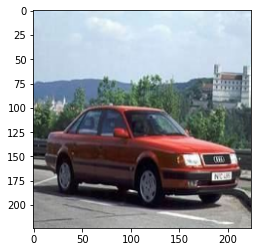

In [13]:
plt.imshow(trainX[0])

In [14]:
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
print(trainX.shape)
print(testX.shape)

(554, 224, 224, 3, 1)
(188, 224, 224, 3, 1)


In [15]:
norm_trainY = utils.normalize_labels(trainY)
norm_testY = utils.normalize_labels(testY)

In [16]:
oh_train = tf.one_hot(norm_trainY, len(np.unique(norm_trainY)))
oh_test = tf.one_hot(norm_testY, len(np.unique(norm_testY)))

In [17]:
vgg16 = tf.keras.applications.VGG16(include_top=True, weights=None,input_shape=trainX.shape[1:4], classes=total_classes)

In [18]:
vgg16 = build_vgg16(trainX.shape[1:4])

In [19]:
vgg16.summary()

Model: "VGG16_confA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       

In [20]:
inputs = Input(shape=trainX.shape[1:4])
vgg16_outputs = vgg16(inputs)
outputs = Dense(len(np.unique(norm_trainY)), activation='relu')(vgg16_outputs)
model = Model(inputs, outputs)

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
	metrics=["categorical_accuracy"])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
VGG16_confA (Model)          (None, 128)               129290752 
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 129,292,042
Trainable params: 129,292,042
Non-trainable params: 0
_________________________________________________________________


In [35]:
class TensorboardCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir):
        self.writer = tf.summary.create_file_writer(log_dir)
        self.writer.set_as_default()

    def on_epoch_end(self, epoch, logs=None):
        tf.summary.scalar('Train/Loss', logs['loss'], epoch)
        tf.summary.scalar('Train/Accuracy', logs['categorical_accuracy'], epoch)
        tf.summary.scalar('Val/Loss', logs['val_loss'], epoch)
        tf.summary.scalar('Val/Accuracy', logs['val_categorical_accuracy'], epoch)


In [47]:
TB_LOG_DIR, SAVE_MODELS_DIR = create_datetime_dirs(ROOT_DIR)
tb_callback = TensorboardCallback(TB_LOG_DIR)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(SAVE_MODELS_DIR, monitor='val_categorical_accuracy', verbose=0, save_best_only=True,
                                                           save_weights_only=False, mode='auto', save_freq='epoch')

history = model.fit(
	trainX, oh_train,
	validation_data=(trainX, oh_train),
	batch_size=batch_size, 
	epochs=epochs,
    callbacks=[tb_callback, checkpoint_callback],
    verbose=1)

Epoch 1/5000
5/5 [==============================] - 4s 741ms/step - loss: 6.1939 - categorical_accuracy: 0.0939 - val_loss: 6.1938 - val_categorical_accuracy: 0.0939
Epoch 2/5000
5/5 [==============================] - 2s 336ms/step - loss: 6.1939 - categorical_accuracy: 0.0939 - val_loss: 6.1937 - val_categorical_accuracy: 0.0939
Epoch 3/5000
5/5 [==============================] - 2s 338ms/step - loss: 6.1938 - categorical_accuracy: 0.0939 - val_loss: 6.1936 - val_categorical_accuracy: 0.0939
Epoch 4/5000
5/5 [==============================] - 2s 337ms/step - loss: 6.1937 - categorical_accuracy: 0.0939 - val_loss: 6.1936 - val_categorical_accuracy: 0.0939
Epoch 5/5000
5/5 [==============================] - 2s 350ms/step - loss: 6.1936 - categorical_accuracy: 0.0939 - val_loss: 6.1935 - val_categorical_accuracy: 0.0939
Epoch 6/5000
5/5 [==============================] - 2s 337ms/step - loss: 6.1935 - categorical_accuracy: 0.0939 - val_loss: 6.1934 - val_categorical_accuracy: 0.0939
Epoc

KeyboardInterrupt: 